# Libraries

In [1]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import math
import logging

# Data loading and exploration

In [2]:
IMG_SHAPE  = 299
batch_size = 32
random_seed = 9

In [3]:
fpath = '/content/drive/MyDrive/Dataset'
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['open', 'closed'] 

No. of categories =  2


In [4]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  2422 
No. of labels loaded =  2422
<class 'list'> <class 'list'>


In [5]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (2422, 299, 299, 3) 
Labels shape =  (2422,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


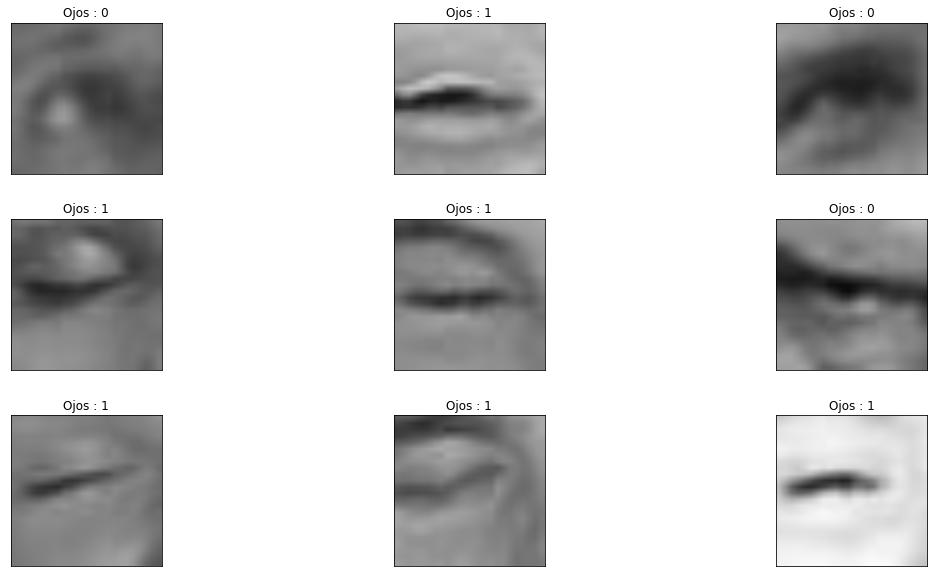

In [6]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Ojos : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

# Prepare data for training the CNN model

In [7]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 2419 2420 2421]

'n' values after shuffling =  [ 737 2294  456 ...  501  348  382]


In [8]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (2422, 299, 299, 3) 
Labels shape after shuffling =  (2422,)


In [9]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (2422, 299, 299, 3)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (1879, 299, 299, 3)
y_train shape =  (1879,)

x_test shape =  (485, 299, 299, 3)
y_test shape =  (485,)

x_val shape =  (58, 299, 299, 3)
y_val shape =  (58,)


In [11]:
##One-hot-encode
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)

# Define CNN model

In [12]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(x_train) 
test_ds = preprocess_input(x_test)

In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [14]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='sigmoid')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

# Train model

In [15]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])


In [16]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [17]:
x_train.shape,y_train.shape

((1879, 299, 299, 3), (1879, 3))

In [18]:
start_time = time.time()

history = model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

logging.basicConfig(filename="CNN-basedTL_InceptionV3log.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/50
47/47 [==============================] - 41s 536ms/step - loss: 0.7243 - acc: 0.4857 - val_loss: 0.6978 - val_acc: 0.4867
Epoch 2/50
47/47 [==============================] - 17s 358ms/step - loss: 0.7347 - acc: 0.5269 - val_loss: 0.7546 - val_acc: 0.4867
Epoch 3/50
47/47 [==============================] - 17s 361ms/step - loss: 0.7164 - acc: 0.5077 - val_loss: 0.7669 - val_acc: 0.4867
Epoch 4/50
47/47 [==============================] - 17s 359ms/step - loss: 0.7348 - acc: 0.4731 - val_loss: 0.6950 - val_acc: 0.4867
Epoch 5/50
47/47 [==============================] - 17s 358ms/step - loss: 0.7078 - acc: 0.5130 - val_loss: 0.6926 - val_acc: 0.4867
Epoch 6/50
47/47 [==============================] - 17s 357ms/step - loss: 0.6985 - acc: 0.5063 - val_loss: 0.7296 - val_acc: 0.4867
Epoch 7/50
47/47 [==============================] - 17s 357ms/step - loss: 0.7022 - acc: 0.4963 - val_loss: 0.6919 - val_acc: 0.5133
Epoch 8/50
47/47 [==============================] - 17s 357ms/step - 

In [19]:
model_json = model.to_json()
with open("VGG16_Eyes_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("VGG16_Eyes_Classifier.h5")
print("Saved model to disk")
model.save_weights("VGG16_.h5")

Saved model to disk


# Evaluation model

In [20]:
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

16/16 [==============================] - 6s 347ms/step - loss: 0.6916 - acc: 0.5196
test_loss: 69.16
test_accuracy: 51.96


In [21]:
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
y_pred = model_probs
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 51.96
F1 score: 35.53
Precision: 27.00
Recall: 51.96


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


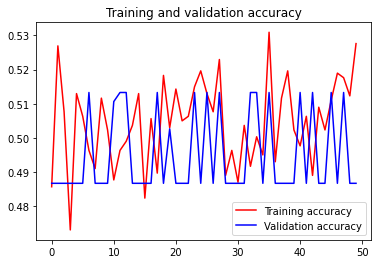

In [22]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TL.png")
plt.show()
model.save('CNN-based TL_InceptionV3.h5')

In [23]:
y_pred.round()

array([[1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       ...,
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.]], dtype=float32)

In [29]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1)

In [34]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion) 

Confusion Matrix

[[252   0]
 [233   0]]


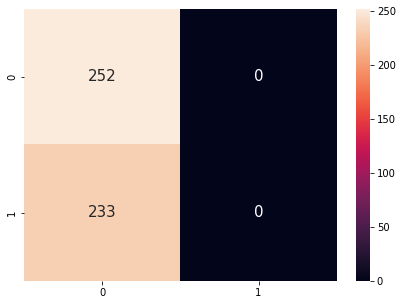

In [35]:
import seaborn as sns
plt.figure(figsize=(7, 5))

sns.heatmap(confusion, annot=True,  annot_kws={'size': 15}, fmt = "d")
plt.show()